In [1]:
#KÜTÜPHANELERİ İMPORT ETME#
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,learning_curve,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression


In [2]:
#Dataframe Oluşturma işlemi#
data=pd.read_csv("credit_risk.csv")
df=pd.DataFrame(data)
print(df.isnull().sum())

Id                   0
Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64


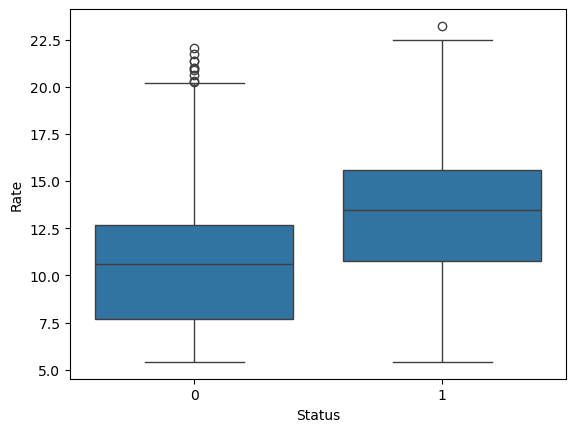

In [3]:
#Rate sınıfı aykırı değerlerin grafikte tespit edilmesi
sns.boxplot(x="Status",y="Rate",data=df)
plt.show()

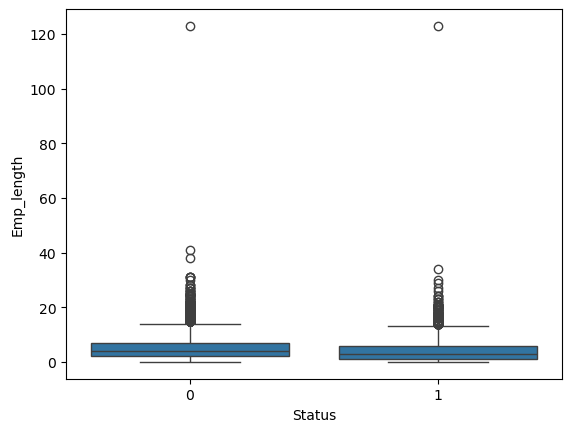

In [4]:
#emp_length sutunu degerlerinin boxplot grafiğine yansıtılarak aykırı değerlerin grafik uzerinde gösterilmesi
#aykırı degerler için 25 yıldan sonra başlıyor diyebiliriz
sns.boxplot(x="Status",y="Emp_length",data=df)
plt.show()

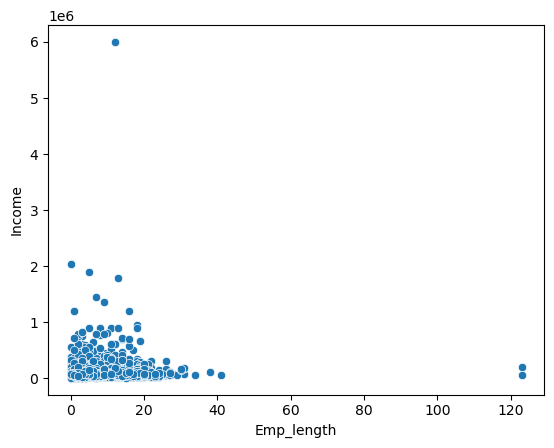

Id                   0
Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64


In [5]:
#normalize endilmemiş ve aykırı degerleri bulunan emp_length özelliginin Income sutununa göre scatterplot grafiği 
#Görüldüğüğ üzere emp_length tarafında 120+ yıl iş tecrubesi gozukuyor böyle bir durum söz konusu değildir.
sns.scatterplot(x="Emp_length",y="Income",data=df)
plt.show()
print(df.isnull().sum())

In [6]:
#Burada Emp_length sütunu için IQR yontemi uygulanarak alt limit ve ust limit belirlenmiş bu limitlere göre filtreleme yapılmıştır
#IQR yönteminde varsayılan degerler 1,5*IQR_degeri iken burada emp_length sutununun boxplot grafiğini ele alarak parametreler
#deneme yanılma yöntemi ile belirlenmiştir.
# IQR hesaplama (Standart Q1 ve Q3 kullanımı)
Q1 = df["Emp_length"].quantile(0.25)  # 1. çeyrek
Q3 = df["Emp_length"].quantile(0.75)  # 3. çeyrek
IQR_emp_length = Q3 - Q1  # IQR hesaplama

# Alt ve üst sınırların belirlenmesi
alt_limit_EmpLength = Q1 - (0.4 * IQR_emp_length)
ust_limit_EmpLength = Q3 + (2.8 * IQR_emp_length)

# Alt ve üst sınırların yazdırılması
print(f"Alt Limit: {alt_limit_EmpLength}")
print(f"Üst Limit: {ust_limit_EmpLength}")



Alt Limit: 0.0
Üst Limit: 21.0


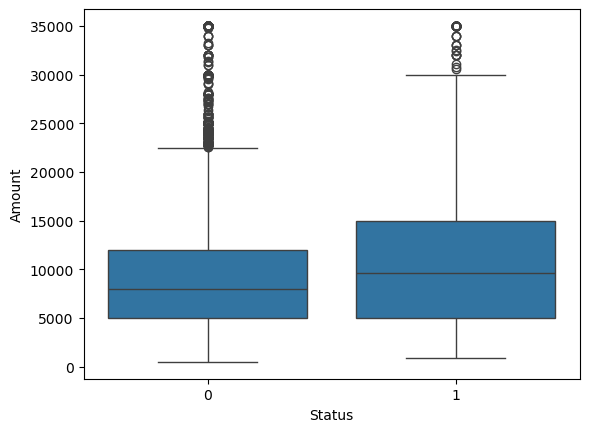

In [7]:
#Amount sutunu degerlerinin boxplot grafiğine yansıtılarak aykırı değerlerin grafik uzerinde gösterilmesi
sns.boxplot(x="Status",y="Amount",data=df)
plt.show()

In [8]:
#IQR işleminin "Amount" sütununa uygulanması
#yine verisetine uygun degerler deneme yabılma yöntemiyle tespit edilmiştir
Q2=df["Amount"].quantile(0.31)
Q4=df["Amount"].quantile(0.69)

IQR_Amount=Q4-Q2

alt_limit_Amount=Q2-(0.1*IQR_Amount)
print(f"alt limit:{alt_limit_Amount}")
ust_limit_Amount=Q4+(2.4*IQR_Amount)
print(f"ust limit:{ust_limit_Amount}")

df_new=df[((df["Amount"]>=alt_limit_Amount) & (df["Amount"]<=ust_limit_Amount)) & ((df["Emp_length"] >= alt_limit_EmpLength) & (df["Emp_length"] <= ust_limit_EmpLength))]

print(df_new)

alt limit:5010.0
ust limit:25660.0
          Id  Age  Income      Home  Emp_length             Intent  Amount  \
2          2   25    9600  MORTGAGE         1.0            MEDICAL    5500   
33        33   25  306000      RENT         2.0  DEBTCONSOLIDATION   24250   
34        34   26  300000  MORTGAGE        10.0            MEDICAL    7800   
42        42   26  300000  MORTGAGE        10.0            VENTURE   20000   
43        43   23  300000       OWN         1.0          EDUCATION   24250   
...      ...  ...     ...       ...         ...                ...     ...   
32574  32574   52   65004      RENT         4.0           PERSONAL   20000   
32576  32576   57   53000  MORTGAGE         1.0           PERSONAL    5800   
32577  32577   54  120000  MORTGAGE         4.0           PERSONAL   17625   
32579  32579   56  150000  MORTGAGE         5.0           PERSONAL   15000   
32580  32780   66   42000      RENT         2.0            MEDICAL    6475   

        Rate  Status  Percen

In [9]:
# Sadece aykırı değerleri seçme
remaining_outliers = df_new[
    (df["Amount"] < alt_limit_Amount) | (df["Amount"] > ust_limit_Amount) |
    (df["Emp_length"] < alt_limit_EmpLength) | (df["Emp_length"] > ust_limit_EmpLength)
]

print("Kalan aykırı değerler:")
print(remaining_outliers)


Kalan aykırı değerler:
Empty DataFrame
Columns: [Id, Age, Income, Home, Emp_length, Intent, Amount, Rate, Status, Percent_income, Default, Cred_length]
Index: []


C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\1665127633.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  remaining_outliers = df_new[


In [10]:
#Aykırı deger filtrelemesinden sonra bozulan index degerlerinin tekrar 0,1,2,3,..... sekinde duzeltilmesi
df_new.reset_index(drop=True,inplace=True)
print(df_new)

          Id  Age  Income      Home  Emp_length             Intent  Amount  \
0          2   25    9600  MORTGAGE         1.0            MEDICAL    5500   
1         33   25  306000      RENT         2.0  DEBTCONSOLIDATION   24250   
2         34   26  300000  MORTGAGE        10.0            MEDICAL    7800   
3         42   26  300000  MORTGAGE        10.0            VENTURE   20000   
4         43   23  300000       OWN         1.0          EDUCATION   24250   
...      ...  ...     ...       ...         ...                ...     ...   
22108  32574   52   65004      RENT         4.0           PERSONAL   20000   
22109  32576   57   53000  MORTGAGE         1.0           PERSONAL    5800   
22110  32577   54  120000  MORTGAGE         4.0           PERSONAL   17625   
22111  32579   56  150000  MORTGAGE         5.0           PERSONAL   15000   
22112  32780   66   42000      RENT         2.0            MEDICAL    6475   

        Rate  Status  Percent_income Default  Cred_length  
0  

In [11]:
#yeni dataframe'de boş deger kontrolu
print(df_new.isnull().sum())

Id                   0
Age                  0
Income               0
Home                 0
Emp_length           0
Intent               0
Amount               0
Rate              2094
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64


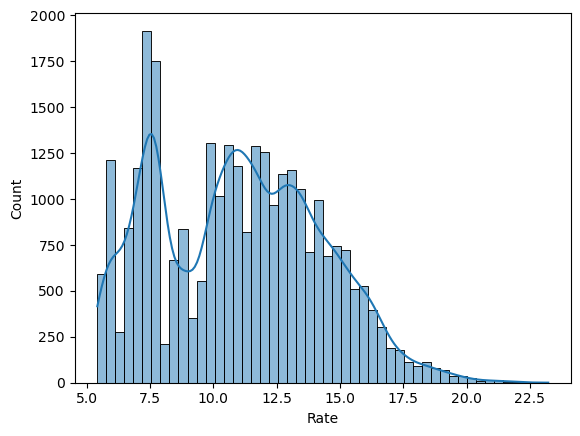

In [12]:
#datasette yer alan "Rate" sütununun eksik verilerini ortalamaya göre mi yoksa mode degerine göre mi verileciğinin analizi
sns.histplot(df["Rate"],kde=True)
plt.show()
#bu grafikten yorumlama yaparsak verilerimiz şu anda surekli ve çan eğrisi şeklinde bir görüntğ sergiliyor.Bu yüzden burada eksik verilerimizi
#ortalama ile doldurabiliriz.

In [13]:
#"Rate" sütunundak eksik verileri ortalama ile doldurma
df_new["Rate"]=df_new["Rate"].fillna(df_new["Rate"].mean())
print(df_new.isnull().sum())

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64


C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\2775466485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Rate"]=df_new["Rate"].fillna(df_new["Rate"].mean())


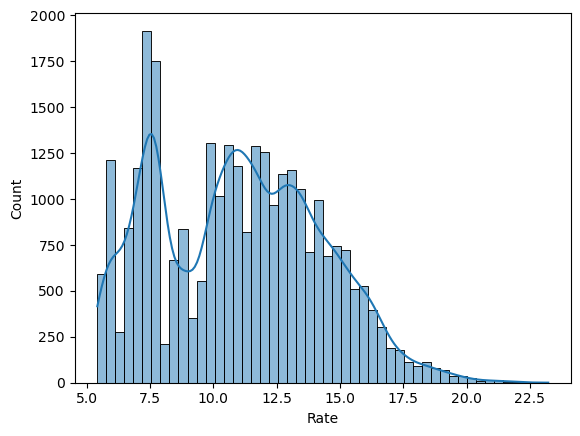

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64


In [14]:
#ortalama deger ile doldurulmus Rate sutununun histogram grafğinin gösterilmesi
sns.histplot(df["Rate"],kde=True)
plt.show()
print(df_new.isnull().sum())

In [15]:
#bos veri kontrolu
print(df_new.isnull().sum())

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64


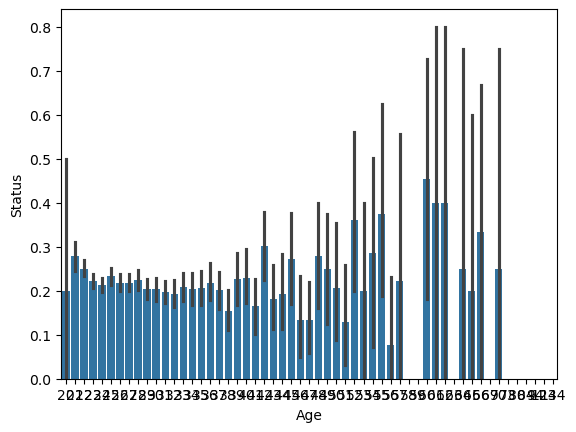

In [16]:
#bu bölümde her bir özelliğin hedef sınıf ile arasındaki ilişki görselleştirilerek gözlemlenmiştir.
sns.barplot(x="Age",y="Status",data=df_new)
plt.show()


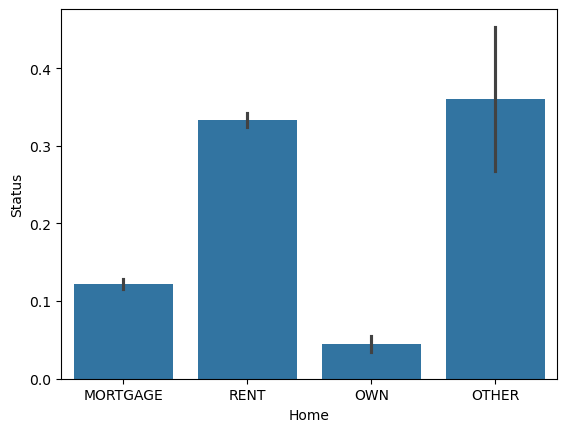

In [17]:
#home özelliğinin içinde bulunan sınıflar ile status arasındaki ilişki
sns.barplot(x="Home",y="Status",data=df_new)
plt.show()

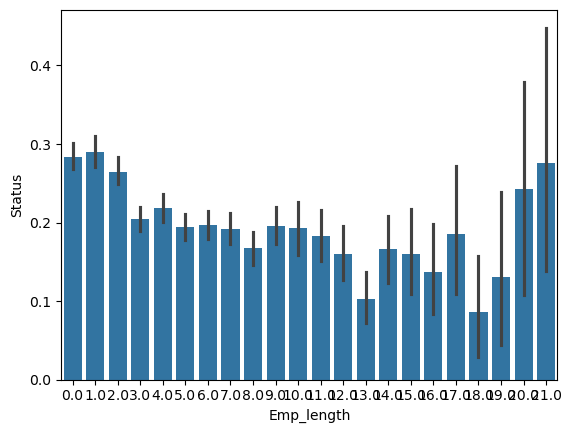

In [18]:
#duzenlenmiş emp_length sutununun hedef değişken arasındaki ilişk
sns.barplot(x="Emp_length",y="Status",data=df_new)
plt.show()

In [19]:
#Normalizasyon işlemleri:Burada max-min Normalizasyon yöntemi kullanılmışır.
#Verileri Normalize etmemizin amacı verilerin ölçeklerinin aynı olmasını sağlamaktır.
Normalizasyon_Columns=["Age",'Income', 'Amount', 'Rate', 'Emp_length',"Cred_length"]
scaler=MinMaxScaler()
df_new[Normalizasyon_Columns]=scaler.fit_transform(df_new[Normalizasyon_Columns])
print(df_new.isnull().sum())

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64


C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\1204454225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[Normalizasyon_Columns]=scaler.fit_transform(df_new[Normalizasyon_Columns])


In [20]:
#yeni df yazdırma
print(df_new)

          Id       Age    Income      Home  Emp_length             Intent  \
0          2  0.040323  0.000787  MORTGAGE    0.047619            MEDICAL   
1         33  0.040323  0.146669      RENT    0.095238  DEBTCONSOLIDATION   
2         34  0.048387  0.143716  MORTGAGE    0.476190            MEDICAL   
3         42  0.048387  0.143716  MORTGAGE    0.476190            VENTURE   
4         43  0.024194  0.143716       OWN    0.047619          EDUCATION   
...      ...       ...       ...       ...         ...                ...   
22108  32574  0.258065  0.028056      RENT    0.190476           PERSONAL   
22109  32576  0.298387  0.022148  MORTGAGE    0.047619           PERSONAL   
22110  32577  0.274194  0.055124  MORTGAGE    0.190476           PERSONAL   
22111  32579  0.290323  0.069889  MORTGAGE    0.238095           PERSONAL   
22112  32780  0.370968  0.016734      RENT    0.095238            MEDICAL   

         Amount      Rate  Status  Percent_income Default  Cred_length  
0 

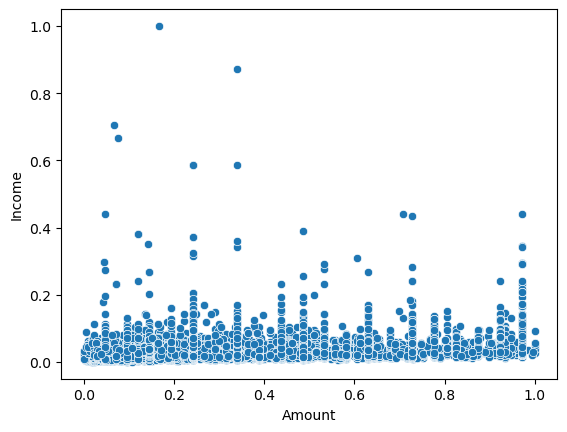

In [21]:
#normalize edilmiş amount verilerini örnek bir scatterplot grafiği olarak Income sutunu ile arasındaki ilişki
sns.scatterplot(x="Amount",y="Income",data=df_new)
plt.show()

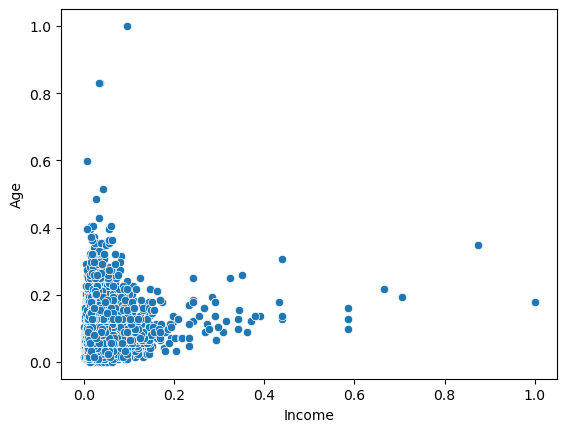

In [22]:
#Normalize edilmiş Income degerlerinin Normalize edilmiş Age degerleri ile scatterplot grafiğinde gösterimi
sns.scatterplot(x="Income",y="Age",data=df_new)
plt.show()


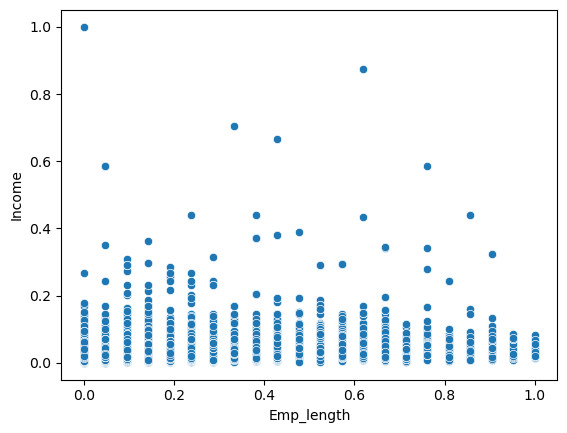

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64


In [23]:
#Normalize edilmil emp_length verileri ile Invome verilerinin grafikte gösterimi
sns.scatterplot(x="Emp_length",y="Income",data=df_new)
plt.show()
print(df_new.isnull().sum())

In [24]:
#Home sutununun benzersiz sınıfları
print(df['Home'].unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER']


In [25]:
#Bu sınıflardan kaç tane bulundugu
print(df_new["Home"].value_counts())

Home
RENT        10789
MORTGAGE     9661
OWN          1577
OTHER          86
Name: count, dtype: int64


In [26]:
#home sınıfında bulunan other ve own sınıflarının birleştirilmesi 
df_new['Home']=df_new['Home'].replace('OTHER','OWN')


C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\786526902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Home']=df_new['Home'].replace('OTHER','OWN')


In [27]:
#Home sutunu sınıf sayılarını yazdırma
print(df_new['Home'].value_counts())

Home
RENT        10789
MORTGAGE     9661
OWN          1663
Name: count, dtype: int64


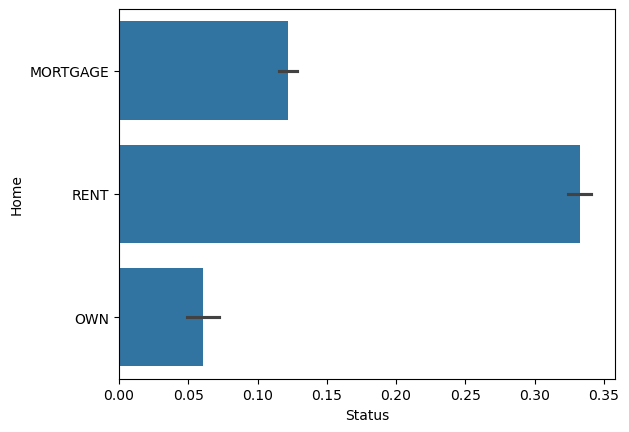

In [28]:
sns.barplot(x="Status",y="Home",data=df_new)
plt.show()

In [29]:
# Kategorik değişkenleri belirleme
categorical_columns = df_new.select_dtypes(include=['object', 'category']).columns.tolist()
print("Kategorik Değişkenler:", categorical_columns)

Kategorik Değişkenler: ['Home', 'Intent', 'Default']


In [30]:
# Orijinal sütunları yedekle
df_new['Home_original'] = df_new['Home']
df_new['Intent_original'] = df_new['Intent']
df_new['Default_original'] = df_new['Default']

C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\4223290976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Home_original'] = df_new['Home']
C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\4223290976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Intent_original'] = df_new['Intent']
C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\4223290976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

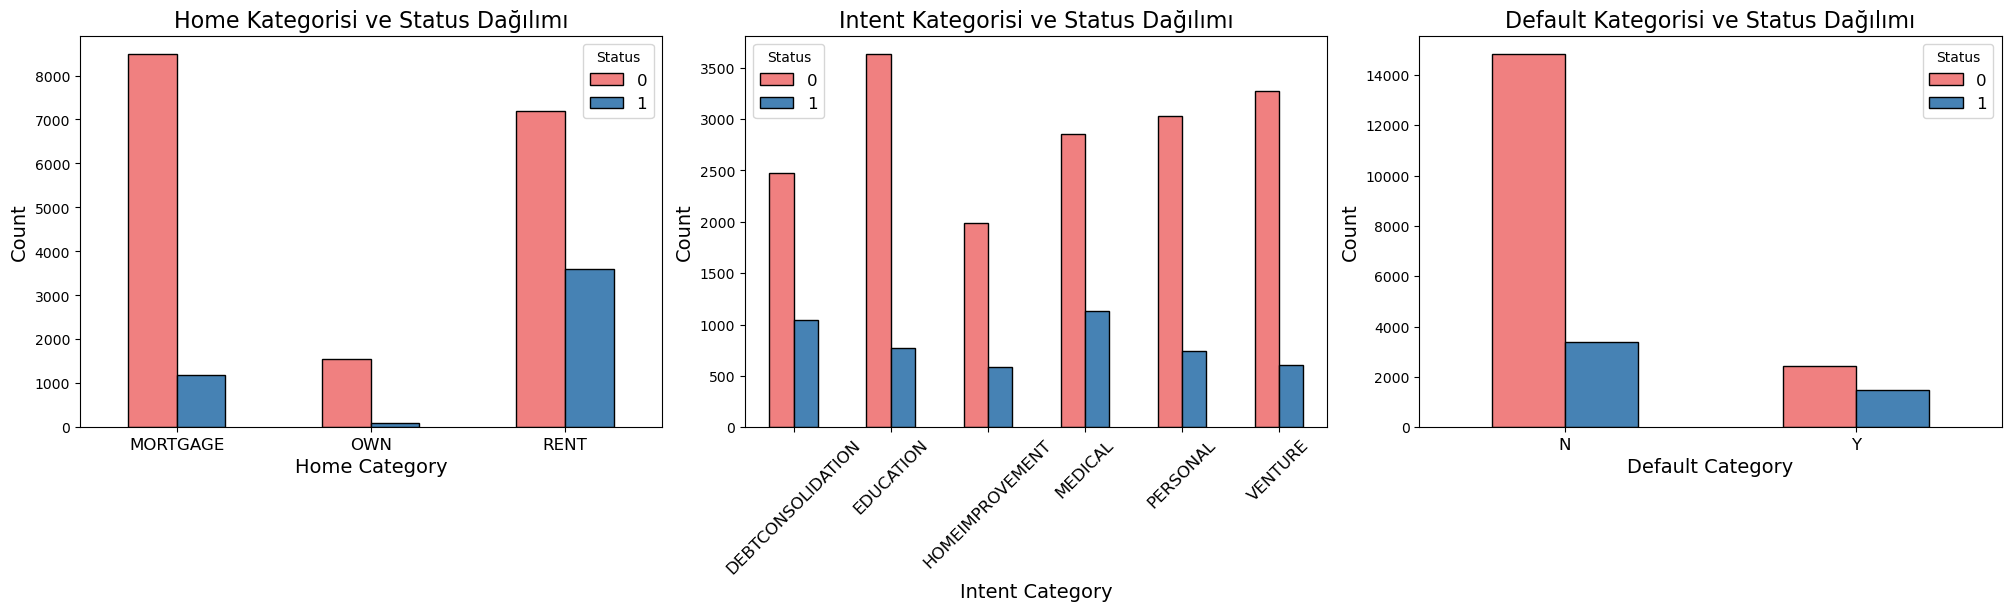

In [31]:
# Home kategorisi için Status'e göre dağılım
home_status_counts = df_new.groupby(['Home_original', 'Status']).size().reset_index(name='Count')
pivot_home_status = home_status_counts.pivot(index='Home_original', columns='Status', values='Count').fillna(0)

# Intent kategorisi için Status'e göre dağılım
intent_status_counts = df_new.groupby(['Intent_original', 'Status']).size().reset_index(name='Count')
pivot_intent_status = intent_status_counts.pivot(index='Intent_original', columns='Status', values='Count').fillna(0)

# Default kategorisi için Status'e göre dağılım
default_status_counts = df_new.groupby(['Default_original', 'Status']).size().reset_index(name='Count')
pivot_default_status = default_status_counts.pivot(index='Default_original', columns='Status', values='Count').fillna(0)

# Hepsini yan yana çiz
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# Home kategorisi grafiği
pivot_home_status.plot(kind='bar', ax=axes[0], color=['lightcoral', 'steelblue'], edgecolor='black')
axes[0].set_title("Home Kategorisi ve Status Dağılımı", fontsize=16)
axes[0].set_xlabel("Home Category", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].tick_params(axis='x', rotation=0, labelsize=12)
axes[0].legend(title="Status", fontsize=12)

# Intent kategorisi grafiği
pivot_intent_status.plot(kind='bar', ax=axes[1], color=['lightcoral', 'steelblue'], edgecolor='black')
axes[1].set_title("Intent Kategorisi ve Status Dağılımı", fontsize=16)
axes[1].set_xlabel("Intent Category", fontsize=14)
axes[1].set_ylabel("Count", fontsize=14)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].legend(title="Status", fontsize=12)

# Default kategorisi grafiği
pivot_default_status.plot(kind='bar', ax=axes[2], color=['lightcoral', 'steelblue'], edgecolor='black')
axes[2].set_title("Default Kategorisi ve Status Dağılımı", fontsize=16)
axes[2].set_xlabel("Default Category", fontsize=14)
axes[2].set_ylabel("Count", fontsize=14)
axes[2].tick_params(axis='x', rotation=0, labelsize=12)
axes[2].legend(title="Status", fontsize=12)

# Grafikleri göster
plt.show()



In [32]:

#burada Home sutununa one-hot encoder uygulanmıstır ve kategorik olan veriler sayısal verilere donusturulmustur.
#one-hot encoder uygulanmasının sebebi ise burada own,rent ve mortgage sınıflarınınn arasında mantıksal bir sıralama bulunmamasıdır.
#ome-hot encoder içine dummy tuzagından kaçmak için drop='first' parametre olarak verilmiştir
encoder=OneHotEncoder(sparse_output=False,drop='first')
encoded=encoder.fit_transform(df_new[["Home"]])

encoded_df_new=pd.DataFrame(encoded,columns=encoder.get_feature_names_out(['Home']))
df_new=pd.concat([df_new,encoded_df_new],axis=1)


In [33]:
#one-hot encoding own,rent ve mortgage için ayrı ayrı 3 sutun olusturur ancak bu bir hataya sebep olabilir olusturulacak 3 sutunda
#1 ve 0 gibi degerler ile tespit edilecektir ve biz buradan aslında bir matris olusturabiliriz
# örneğin 1,0,0 ise own 0,1,0 ise rent veyya 0,0,1 ise mortgage oalcaktır ve böyle bu durumda bu matrisleri
# matematiksel olarak gösterebliriz ve 3 sutun arasında bir baglantı kurmus oluruz ve bu modelin olumsuz yonde etkilenmesine yol açar
# bu sebeple paramtre olarak drop='first' uygularız ve olusacak bir sutunu yok ederiz 
# burada drop edilen sutun manuel olarak olusturulur. 
df_new['Home_MORTGAGE'] = ((df_new['Home_OWN'] == 0.0) & (df_new['Home_RENT'] == 0.0)).astype(int)

# Sonuçları İnceleme
print("Home_OWN, Home_RENT ve Home_MORTGAGE Değerleri:")
print(df_new[['Home_OWN', 'Home_RENT', 'Home_MORTGAGE']])
print(df_new)


Home_OWN, Home_RENT ve Home_MORTGAGE Değerleri:
       Home_OWN  Home_RENT  Home_MORTGAGE
0           0.0        0.0              1
1           0.0        1.0              0
2           0.0        0.0              1
3           0.0        0.0              1
4           1.0        0.0              0
...         ...        ...            ...
22108       0.0        1.0              0
22109       0.0        0.0              1
22110       0.0        0.0              1
22111       0.0        0.0              1
22112       0.0        1.0              0

[22113 rows x 3 columns]
          Id       Age    Income      Home  Emp_length             Intent  \
0          2  0.040323  0.000787  MORTGAGE    0.047619            MEDICAL   
1         33  0.040323  0.146669      RENT    0.095238  DEBTCONSOLIDATION   
2         34  0.048387  0.143716  MORTGAGE    0.476190            MEDICAL   
3         42  0.048387  0.143716  MORTGAGE    0.476190            VENTURE   
4         43  0.024194  0.143716     

In [34]:

encoder=OneHotEncoder(sparse_output=False,drop='first')
encoded=encoder.fit_transform(df_new[["Intent"]])

encoded_df_new=pd.DataFrame(encoded,columns=encoder.get_feature_names_out(['Intent']))
df_new=pd.concat([df_new,encoded_df_new],axis=1)


In [35]:
df_new['Intent_DEBTCONSOLIDATION'] = ((df_new["Intent_EDUCATION"] == 0.0) & (df_new["Intent_HOMEIMPROVEMENT"] == 0.0)&(df_new["Intent_MEDICAL"] == 0.0) & (df_new["Intent_VENTURE"] == 0.0)&(df_new["Intent_PERSONAL"] == 0.0)).astype(int)
print(df_new.isnull().sum())

Id                          0
Age                         0
Income                      0
Home                        0
Emp_length                  0
Intent                      0
Amount                      0
Rate                        0
Status                      0
Percent_income              0
Default                     0
Cred_length                 0
Home_original               0
Intent_original             0
Default_original            0
Home_OWN                    0
Home_RENT                   0
Home_MORTGAGE               0
Intent_EDUCATION            0
Intent_HOMEIMPROVEMENT      0
Intent_MEDICAL              0
Intent_PERSONAL             0
Intent_VENTURE              0
Intent_DEBTCONSOLIDATION    0
dtype: int64


In [36]:
#default sutunu içerisinde sadece yes ve no sınıfları bulundugundan ve bunlar arasında bir oncelik sıralamsı oldugundan dolayı label encoding yapılabilir.
Label_encoder=LabelEncoder()
df_new["Default"]=Label_encoder.fit_transform(df_new["Default"])
print(df_new["Default"].head)

<bound method NDFrame.head of 0        0
1        0
2        0
3        0
4        1
        ..
22108    1
22109    0
22110    0
22111    0
22112    0
Name: Default, Length: 22113, dtype: int32>


In [37]:
print(df_new.isnull().sum())

Id                          0
Age                         0
Income                      0
Home                        0
Emp_length                  0
Intent                      0
Amount                      0
Rate                        0
Status                      0
Percent_income              0
Default                     0
Cred_length                 0
Home_original               0
Intent_original             0
Default_original            0
Home_OWN                    0
Home_RENT                   0
Home_MORTGAGE               0
Intent_EDUCATION            0
Intent_HOMEIMPROVEMENT      0
Intent_MEDICAL              0
Intent_PERSONAL             0
Intent_VENTURE              0
Intent_DEBTCONSOLIDATION    0
dtype: int64


In [38]:
#kaegorik verileri yazdırma
categorical_columns = df_new.select_dtypes(include=['object', 'category']).columns.tolist()
print("Kategorik Değişkenler:", categorical_columns)

Kategorik Değişkenler: ['Home', 'Intent', 'Home_original', 'Intent_original', 'Default_original']


In [39]:
#one hot encoding yapılmadan önce yedeklenen sutunları dataframe'den kaldırma
df_new.drop(columns=["Home_original","Intent_original","Default_original"],inplace=True)

In [40]:
print(df_new.isnull().sum())

Id                          0
Age                         0
Income                      0
Home                        0
Emp_length                  0
Intent                      0
Amount                      0
Rate                        0
Status                      0
Percent_income              0
Default                     0
Cred_length                 0
Home_OWN                    0
Home_RENT                   0
Home_MORTGAGE               0
Intent_EDUCATION            0
Intent_HOMEIMPROVEMENT      0
Intent_MEDICAL              0
Intent_PERSONAL             0
Intent_VENTURE              0
Intent_DEBTCONSOLIDATION    0
dtype: int64


In [41]:
#artık home ve Intent sutunlarını sayısal olarak ifade ettiğimizden dolayı drop edebiliriz
df_new.drop(columns=["Home","Intent"],inplace=True)

In [42]:
#gereksiz sutunları kaldırma
print(df_new.isnull().sum())
df_new.drop(columns=["Id"],inplace=True)


Id                          0
Age                         0
Income                      0
Emp_length                  0
Amount                      0
Rate                        0
Status                      0
Percent_income              0
Default                     0
Cred_length                 0
Home_OWN                    0
Home_RENT                   0
Home_MORTGAGE               0
Intent_EDUCATION            0
Intent_HOMEIMPROVEMENT      0
Intent_MEDICAL              0
Intent_PERSONAL             0
Intent_VENTURE              0
Intent_DEBTCONSOLIDATION    0
dtype: int64


In [43]:
#kategorik veri kontrolu
categorical_columns = df_new.select_dtypes(include=['object', 'category']).columns.tolist()
print("Kategorik Değişkenler:", categorical_columns)


Kategorik Değişkenler: []


In [44]:
#yukarıda own sınıfının veri sayısının diğer sınıflardan az oldugunu ve bir dengesizlik arattıgını belirtmistik burada o dengesizliği gidermek için işlemler yapılmıstır
# OWN sınıfındaki verileri seçme
own_data = df_new[df_new['Home_OWN'] == 1]

# OWN sınıfını çoğaltarak veri setine ekleme
needed_samples = len(df_new[df_new['Home_RENT'] == 1]) - len(own_data)
own_data_duplicated = own_data.sample(n=needed_samples, replace=True, random_state=42)

# Yeni veri setini birleştirme
df_new = pd.concat([df_new, own_data_duplicated], axis=0).reset_index(drop=True)

# Sonuçları kontrol etme
print("Yeni veri setindeki sınıf dağılımı:")
print(df_new['Home_OWN'].value_counts())


Yeni veri setindeki sınıf dağılımı:
Home_OWN
0.0    20450
1.0    10789
Name: count, dtype: int64


In [45]:
#sınıf sayısı kontrolu
print(df_new["Home_OWN"].value_counts())
print(df_new["Home_RENT"].value_counts())
print(df_new["Home_MORTGAGE"].value_counts())

Home_OWN
0.0    20450
1.0    10789
Name: count, dtype: int64
Home_RENT
0.0    20450
1.0    10789
Name: count, dtype: int64
Home_MORTGAGE
0    21578
1     9661
Name: count, dtype: int64


In [46]:
#aynı seklde bir dengesiz durum daha default sutununda bulunmaktadırr bu yuzden bu sutuna da aynı işlemler sutun ozelinde yapılmıstır
#OWN sınıfındaki verileri seçme
own_data = df_new[df_new['Default'] == 1]

# OWN sınıfını çoğaltarak veri setine ekleme
needed_samples = len(df_new[df_new['Default'] == 0]) - len(own_data)
own_data_duplicated = own_data.sample(n=needed_samples, replace=True, random_state=42)

# Yeni veri setini birleştirme
df_new = pd.concat([df_new, own_data_duplicated], axis=0).reset_index(drop=True)

# Sonuçları kontrol etme
print("Yeni veri setindeki sınıf dağılımı:")
print(df_new['Default'].value_counts())

Yeni veri setindeki sınıf dağılımı:
Default
0    25563
1    25563
Name: count, dtype: int64


In [47]:
#sınıf sayısı kontrolu
print(df_new["Home_OWN"].value_counts())
print(df_new["Home_RENT"].value_counts())
print(df_new["Home_MORTGAGE"].value_counts())

Home_OWN
0.0    33061
1.0    18065
Name: count, dtype: int64
Home_RENT
0.0    32977
1.0    18149
Name: count, dtype: int64
Home_MORTGAGE
0    36214
1    14912
Name: count, dtype: int64


In [48]:
print(df_new["Default"].value_counts())

Default
0    25563
1    25563
Name: count, dtype: int64


In [49]:
#hedef degişkeninin verilerinde de bir dengesizlik söz konusudur bu dengesizlik overfitting ya da underfitting olusturabilir bu yuzden 
#bu sutuna da manurl arttırma işlemi uygulanmıstır.
# OWN sınıfındaki verileri seçme
own_data = df_new[df_new['Status'] == 1]

# OWN sınıfını çoğaltarak veri setine ekleme
needed_samples = len(df_new[df_new['Status'] == 0]) - len(own_data)
own_data_duplicated = own_data.sample(n=needed_samples, replace=True, random_state=42)

# Yeni veri setini birleştirme
df_new = pd.concat([df_new, own_data_duplicated], axis=0).reset_index(drop=True)

# Sonuçları kontrol etme
print("Yeni veri setindeki sınıf dağılımı:")
print(df_new['Status'].value_counts())

Yeni veri setindeki sınıf dağılımı:
Status
1    39750
0    39750
Name: count, dtype: int64


In [50]:
#olusturulan son df_new yeni.csv dosyasına donusturulmustur
df_new.to_csv("yeni.csv")

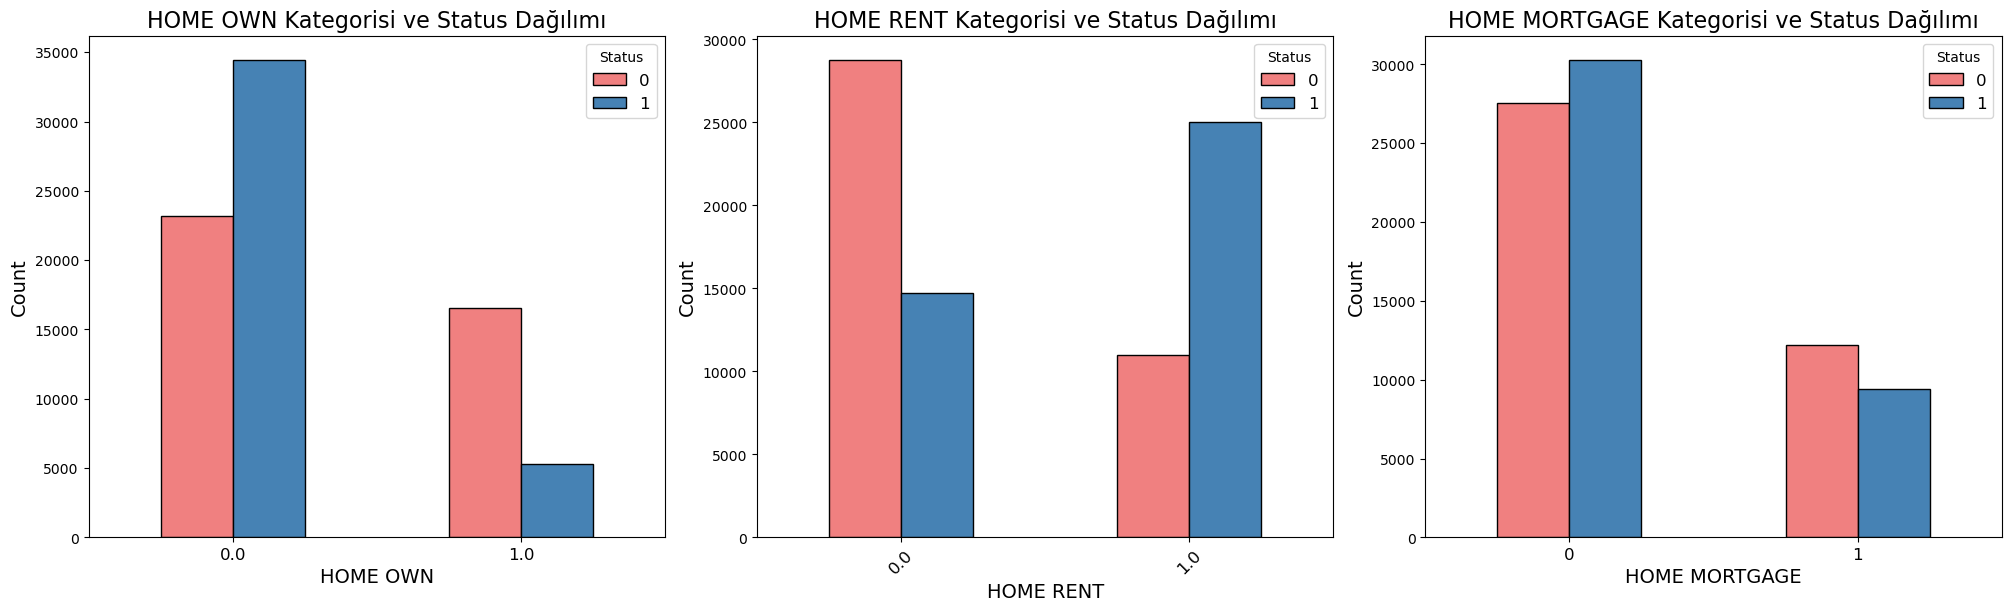

In [51]:
# Home kategorisi için Status'e göre dağılım
home_status_counts = df_new.groupby(['Home_OWN', 'Status']).size().reset_index(name='Count')
pivot_home_status = home_status_counts.pivot(index='Home_OWN', columns='Status', values='Count').fillna(0)

# Intent kategorisi için Status'e göre dağılım
intent_status_counts = df_new.groupby(['Home_RENT', 'Status']).size().reset_index(name='Count')
pivot_intent_status = intent_status_counts.pivot(index='Home_RENT', columns='Status', values='Count').fillna(0)

# Default kategorisi için Status'e göre dağılım
default_status_counts = df_new.groupby(['Home_MORTGAGE', 'Status']).size().reset_index(name='Count')
pivot_default_status = default_status_counts.pivot(index='Home_MORTGAGE', columns='Status', values='Count').fillna(0)

# Hepsini yan yana çiz
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)

# Home kategorisi grafiği
pivot_home_status.plot(kind='bar', ax=axes[0], color=['lightcoral', 'steelblue'], edgecolor='black')
axes[0].set_title("HOME OWN Kategorisi ve Status Dağılımı", fontsize=16)
axes[0].set_xlabel("HOME OWN", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)
axes[0].tick_params(axis='x', rotation=0, labelsize=12)
axes[0].legend(title="Status", fontsize=12)

# Intent kategorisi grafiği
pivot_intent_status.plot(kind='bar', ax=axes[1], color=['lightcoral', 'steelblue'], edgecolor='black')
axes[1].set_title("HOME RENT Kategorisi ve Status Dağılımı", fontsize=16)
axes[1].set_xlabel("HOME RENT", fontsize=14)
axes[1].set_ylabel("Count", fontsize=14)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].legend(title="Status", fontsize=12)

# Default kategorisi grafiği
pivot_default_status.plot(kind='bar', ax=axes[2], color=['lightcoral', 'steelblue'], edgecolor='black')
axes[2].set_title("HOME MORTGAGE Kategorisi ve Status Dağılımı", fontsize=16)
axes[2].set_xlabel("HOME MORTGAGE", fontsize=14)
axes[2].set_ylabel("Count", fontsize=14)
axes[2].tick_params(axis='x', rotation=0, labelsize=12)
axes[2].legend(title="Status", fontsize=12)

# Grafikleri göster
plt.show()

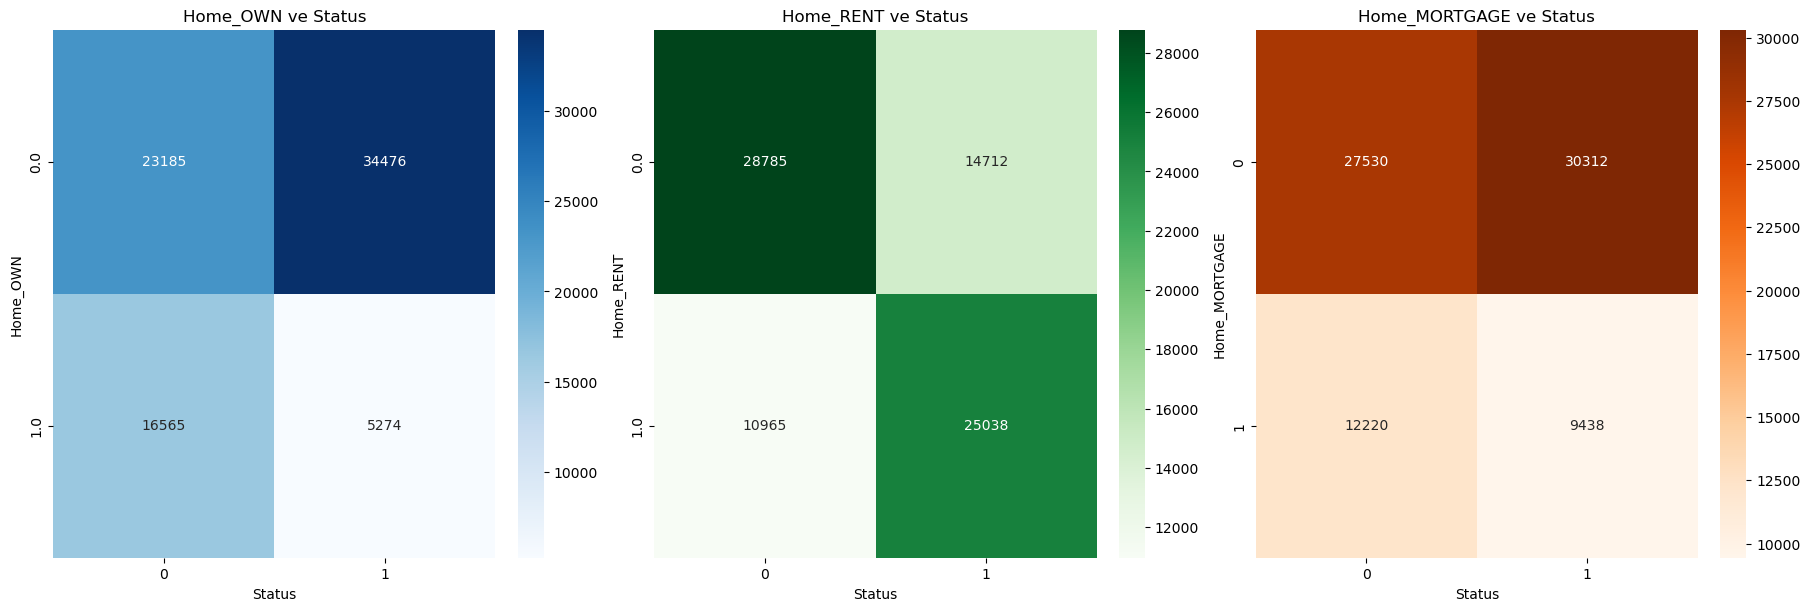

In [52]:
# Home_OWN için pivot tablo
pivot_own = df_new.pivot_table(index='Home_OWN', columns='Status', aggfunc='size', fill_value=0)

# Home_RENT için pivot tablo
pivot_rent = df_new.pivot_table(index='Home_RENT', columns='Status', aggfunc='size', fill_value=0)

# Home_MORTGAGE için pivot tablo
pivot_mortgage = df_new.pivot_table(index='Home_MORTGAGE', columns='Status', aggfunc='size', fill_value=0)


# Yan yana 3 grafik için bir figür oluşturun
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Heatmap 1: Home_OWN
sns.heatmap(pivot_own, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Home_OWN ve Status')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Home_OWN')

# Heatmap 2: Home_RENT
sns.heatmap(pivot_rent, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Home_RENT ve Status')
axes[1].set_xlabel('Status')
axes[1].set_ylabel('Home_RENT')

# Heatmap 3: Home_MORTGAGE
sns.heatmap(pivot_mortgage, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('Home_MORTGAGE ve Status')
axes[2].set_xlabel('Status')
axes[2].set_ylabel('Home_MORTGAGE')

# Grafikleri göster
plt.show()


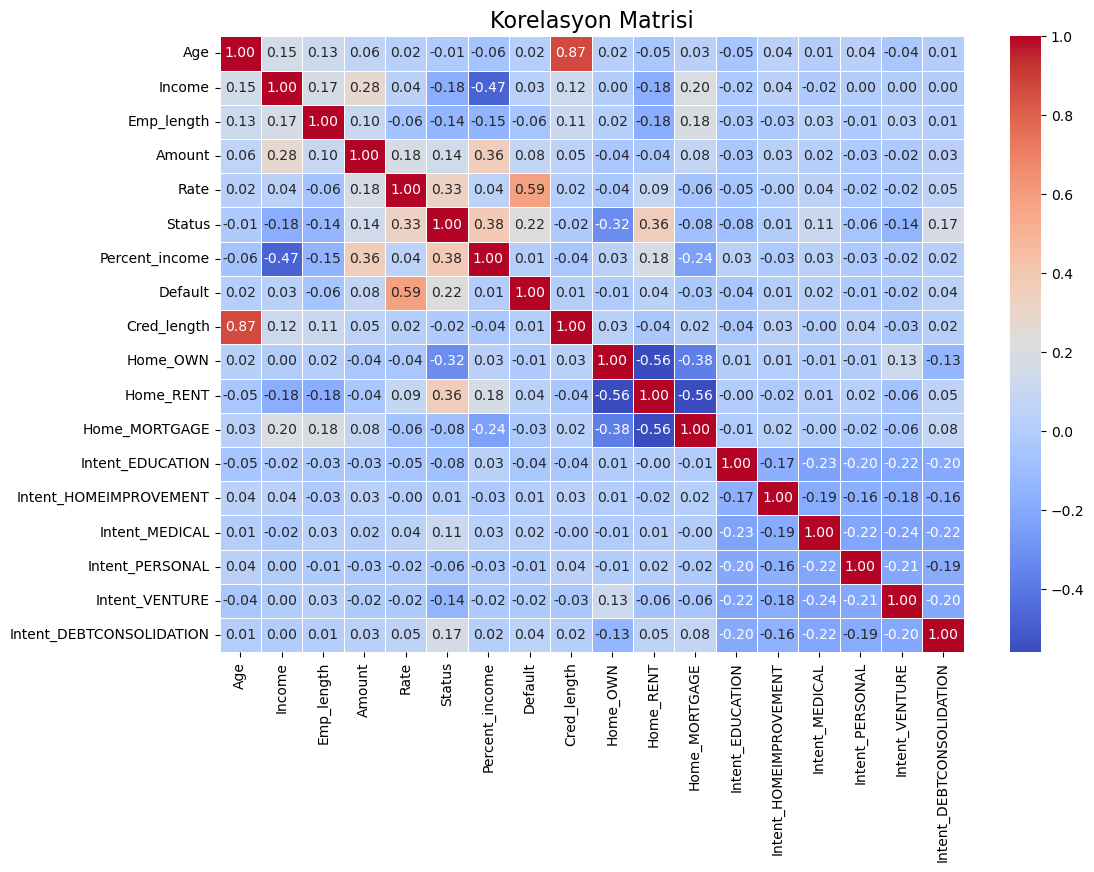

In [53]:
# Korelasyon matrisi hesaplama
correlation_matrix = df_new.corr()
plt.figure(figsize=(12, 8))  # Grafiğin boyutunu ayarla
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Grafik başlığı ve etiketler
plt.title('Korelasyon Matrisi', fontsize=16)
plt.show()


Status
0    25473
1     7108
Name: count, dtype: int64


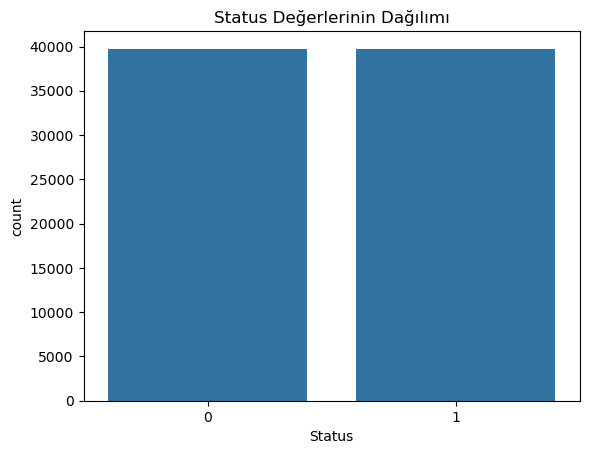

In [54]:
print(df['Status'].value_counts())
sns.countplot(x='Status', data=df_new)
plt.title('Status Değerlerinin Dağılımı')
plt.show()


In [55]:
#burada model olusturulmus,egitilmis,tahminler uretilmis ve model dogruluk degerleri tek tek yazdırılmıstır
#accuarcy modelin toplam dogru tahminlerinin (true positive+true negative) toplam yapılan tahmin sayısına oranıdır.
#Precision score ise tahmin ettiği 1 sınıfının ne kadarının gercekte 1 oldugunu gösterir
#recall score ise gercekten 1 olan sınıfların ne kadarının 1 olarak tahmin edildiğini gosterir.
# accuarcy score degerlerinde egitim ve test verisi degerleri birbirine yakın ıse modelin asırı oğrenme yapmadıgını soyleyebiliriz 
a= df_new.drop('Status', axis=1)  # Özellikler
b=df_new["Status"]

a_egitim,a_Test,b_egitim,b_Test=train_test_split(a,b,test_size=0.3,random_state=42)

print("Egiitm verisi boyutu: ",a_egitim.shape)
print("Test verisi boyutu: ",a_Test.shape)

logisticRegression=LogisticRegression(random_state=42,max_iter=1000)

logisticRegression.fit(a_egitim,b_egitim)
b_pred_train=logisticRegression.predict(a_egitim)

b_pred_test=logisticRegression.predict(a_Test)

print("Eğitim Seti Performansı:")
print(f"Accuracy: {accuracy_score(b_egitim, b_pred_train):.2f}")
print(f"Precision: {precision_score(b_egitim, b_pred_train):.2f}")
print(f"Recall: {recall_score(b_egitim, b_pred_train):.2f}")
print(f"F1 Score: {f1_score(b_egitim, b_pred_train):.2f}")


print("\nTest Seti Performansı:")
print(f"Accuracy: {accuracy_score(b_Test, b_pred_test):.2f}")
print(f"Precision: {precision_score(b_Test, b_pred_test):.2f}")
print(f"Recall: {recall_score(b_Test, b_pred_test):.2f}")
print(f"F1 Score: {f1_score(b_Test, b_pred_test):.2f}")

print("\nConfusion Matrix (Test Seti):")
print(confusion_matrix(b_Test, b_pred_test))










Egiitm verisi boyutu:  (55650, 17)
Test verisi boyutu:  (23850, 17)
Eğitim Seti Performansı:
Accuracy: 0.79
Precision: 0.78
Recall: 0.80
F1 Score: 0.79

Test Seti Performansı:
Accuracy: 0.78
Precision: 0.78
Recall: 0.80
F1 Score: 0.79

Confusion Matrix (Test Seti):
[[9223 2724]
 [2409 9494]]


In [56]:
#burada ise lojistik regresyon modelindeki katsayılar gosterilmiş ve sıralanmıstır yani model sonucunu etkileyen özelliklerin önemi gosterilmiştir.
coefficients = logisticRegression.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': a.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)

                     Feature  Coefficient
5             Percent_income    11.580004
1                     Income     5.916894
4                       Rate     5.014993
0                        Age     1.725219
16  Intent_DEBTCONSOLIDATION     0.410493
6                    Default     0.329544
9                  Home_RENT     0.271263
13            Intent_MEDICAL     0.201048
12    Intent_HOMEIMPROVEMENT    -0.128800
10             Home_MORTGAGE    -0.301030
7                Cred_length    -0.477161
14           Intent_PERSONAL    -0.684574
2                 Emp_length    -0.755186
11          Intent_EDUCATION    -0.900764
3                     Amount    -1.015438
15            Intent_VENTURE    -1.064316
8                   Home_OWN    -2.137145


C:\Users\Tuncer\AppData\Local\Temp\ipykernel_16816\1330431965.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


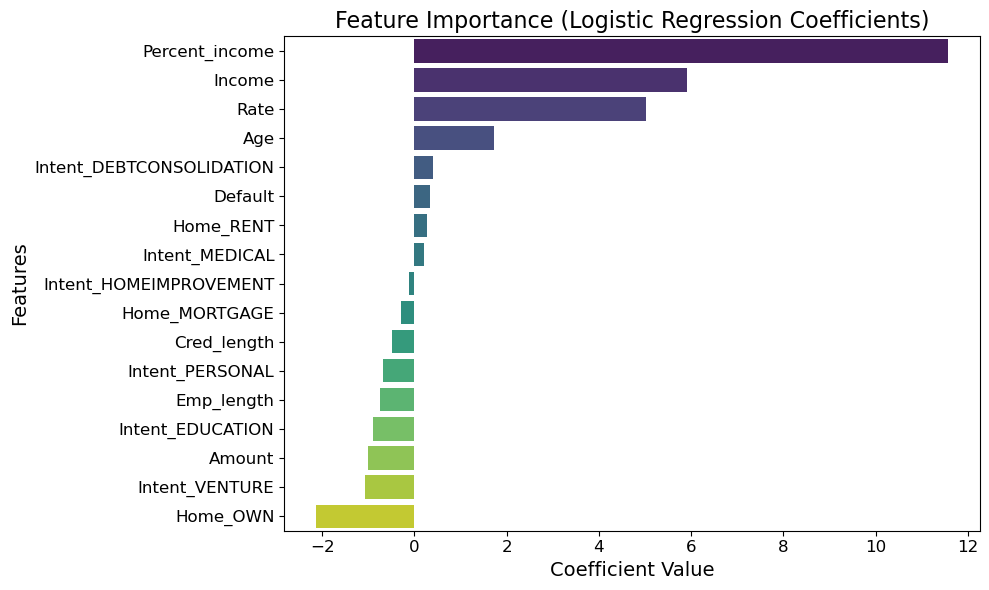

In [57]:
#grafiğe aktarma
# Çubuk grafik çizimi
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')

# Başlık ve eksen etiketleri
plt.title('Feature Importance (Logistic Regression Coefficients)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Grafik gösterimi
plt.tight_layout()
plt.show()


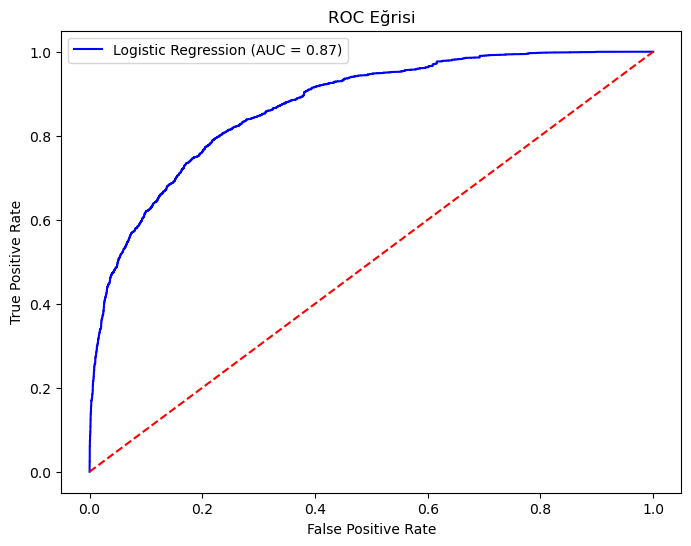

In [58]:
#asagıda bir ROC egrisi ile modelin sınıflandırma performansı acıklanmıstır.
#eger egri y=x dogrusunun ustunde kalıyorsa modelin performansı yuksek olarak kabul edilebilir 
#AUC skoru 0.8 ve 0.9 arasında hesaplanmıs olup çok iyi kategorisine dahildir.
# Model tahmin olasılıkları
b_prob = logisticRegression.predict_proba(a_Test)[:, 1]  # Pozitif sınıf olasılığı

# ROC eğrisi
fpr, tpr, thresholds = roc_curve(b_Test, b_prob)
auc_score = roc_auc_score(b_Test, b_prob)

# Grafiği çizme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Rastgele sınıflandırıcı
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()




c:\Users\Tuncer\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Tuncer\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Tuncer\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Tuncer\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1301, in fit
    raise Va

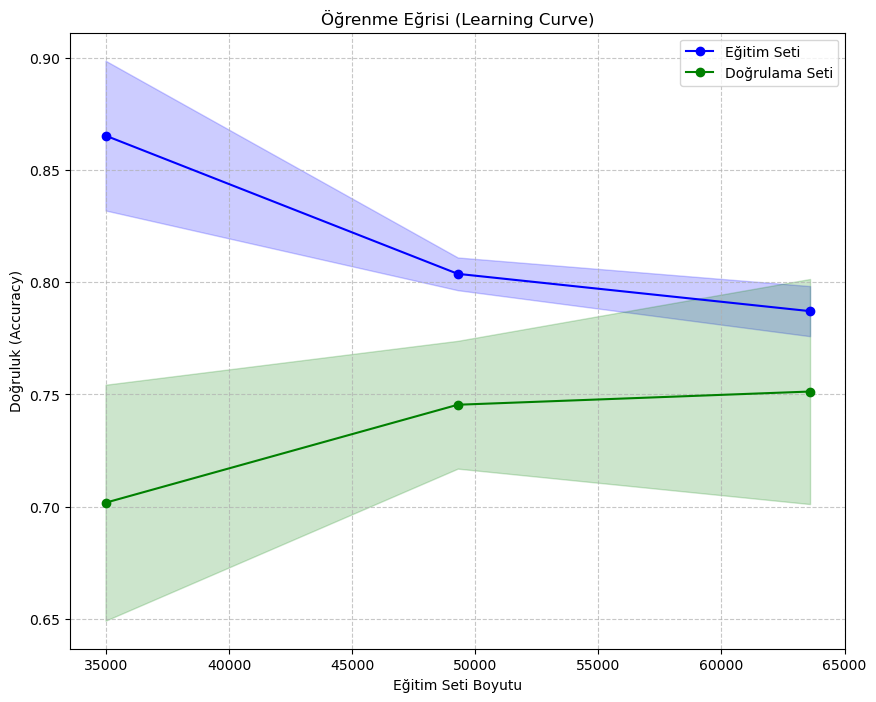

In [59]:
#burada modelin öğrenim durumu görselleştirilmiştir ilk basta yuksek dogruluk ile baslayıp daha sonra bu oran biraz dusup sabitlenmiştir bu modelin
#az veri bulunan verisetlerinde overfitting olma olasılıgını gösterir fakat veri miktarı arttıkca daha stabil calısır hale gelmiştir
#iki grafik arasında kalan alanın git gider azalması modelin guzel performans gosterdiğini ve overfitting gibi olumsuz olayların olmadıgını gösterir
train_sizes, train_scores, test_scores = learning_curve(
    logisticRegression, a,b, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

# Ortalama ve Standart Sapma Hesabı
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Öğrenme Eğrisi Çizimi
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Eğitim Seti")
plt.plot(train_sizes, test_mean, 'o-', color='green', label="Doğrulama Seti")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title("Öğrenme Eğrisi (Learning Curve)")
plt.xlabel("Eğitim Seti Boyutu")
plt.ylabel("Doğruluk (Accuracy)")
plt.legend(loc="best")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


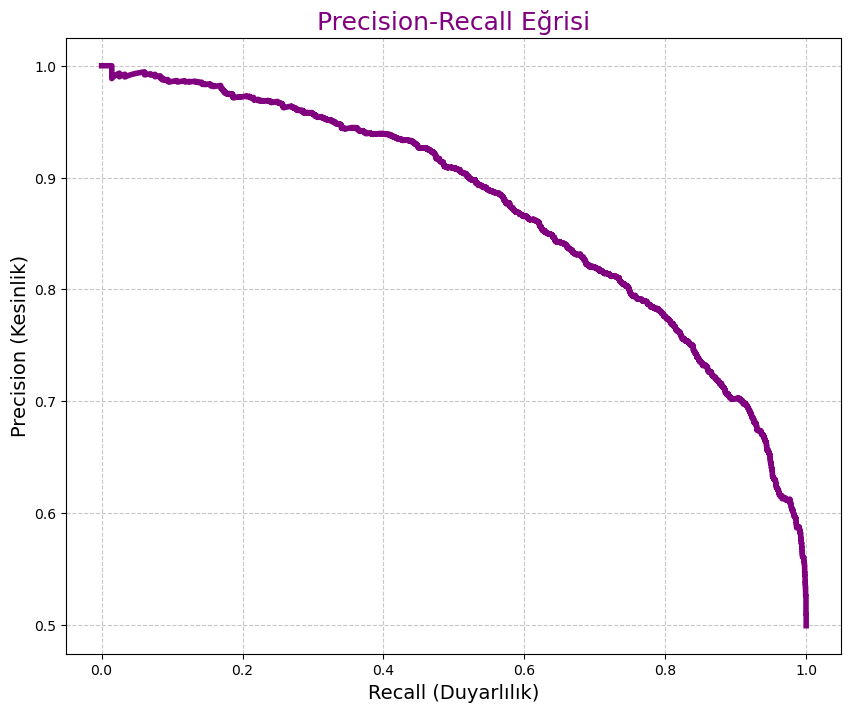

In [60]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall eğrisini hesapla
precision, recall, thresholds = precision_recall_curve(b_Test, b_prob)

# Grafiği çizme
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='purple', lw=4)
plt.title("Precision-Recall Eğrisi", fontsize=18, color='purple')
plt.xlabel("Recall (Duyarlılık)", fontsize=14)
plt.ylabel("Precision (Kesinlik)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
